In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
"""Data : https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images"""

'Data : https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images'

In [9]:
"""Veri normalizasyonu.Test ve val img'leri normalleştirildi."""
data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.76891514,0.77947596,0.80775537],[0.33321657,0.32545126,0.30419493])
    ])

In [10]:
data_dir = "/content/drive/MyDrive/Shoe vs Sandal vs Boot Dataset"
dataset = datasets.ImageFolder(data_dir,transform = data_transforms)

train_size = int(len(dataset) * 0.7)
val_size = (len(dataset) - train_size) // 2
test_size = val_size
"""Test-train-val dağılımı----- %15-70-15"""
print(f"Train Size : {train_size} Val Size : {val_size} Test Size : {test_size}")

Train Size : 10500 Val Size : 2250 Test Size : 2250


In [11]:
"""Rastgele split işlemi"""
train_data,val_data,test_data = torch.utils.data.random_split(dataset,[train_size,val_size,test_size],generator = torch.Generator().manual_seed(42))
class_names = train_data.dataset.classes

In [12]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data,batch_size = batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size = batch_size,shuffle = True)

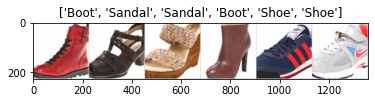

In [14]:
def sh(inp,title = None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.76891514,0.77947596,0.80775537])
    std = np.array([0.33321657,0.32545126,0.30419493])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

"""Veri görselleştirme"""
inputs,classes = next(iter(test_loader))

out = torchvision.utils.make_grid(inputs[0 : 6])
sh(out,title = [class_names[x] for x in classes[0:6]])

In [15]:
dataloaders = {"train" : train_loader,"val" : val_loader,"test" : test_loader}
device = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
dataset_sizes = {"train" : train_size,"val" : val_size,"test" : test_size}
def train_model(model,criterion,optimizer,scheduler,num_epochs = 25):
   #En iyi modelin kaydedilmesi.
   since = time.time()
   best_model_wts = copy.deepcopy(model.state_dict())
   best_acc = 0.0
   for epoch in range(num_epochs):
     print(f"Epoch : {epoch+1} / {num_epochs }")
     print("-" * 10)
     #Her bir epoc için train ve val.
     for phase in ["train","val"]:
       if phase == "train":
         model.train()
       else:
         model.eval()
       running_loss = 0.0
       running_corrects = 0
       for inputs,labels in dataloaders[phase]:
         inputs = inputs.to(device)
         labels = labels.to(device)
         optimizer.zero_grad()
         with torch.set_grad_enabled(phase == "train"):
           outputs = model(inputs)
           _,preds = torch.max(outputs,1)
           loss = criterion(outputs,labels)
           if phase == "train":
             loss.backward()
             optimizer.step()
         #sonuçlar için
         running_loss += loss.item() * inputs.size(0)
         running_corrects += torch.sum(preds == labels.data)
    
       if phase == "train":
         scheduler.step()

       epoch_loss = running_loss / dataset_sizes[phase]
       epoch_acc = running_corrects.double() / dataset_sizes[phase]

       print(f"{phase} Loss : {epoch_loss} Acc {epoch_acc}")
       #Deep copy of the model.
       if phase == "val" and epoch_acc > best_acc:
         best_acc = epoch_acc
         best_model_wts = copy.deepcopy(model.state_dict())

     print()
  
   time_elapsed = time.time() - since
   print(f"time : {time_elapsed // 60}m in {time_elapsed % 60}")
   print(f"Best val accuracy : {best_acc}")

   #En iyi modelin belirlenmesi
   model.load_state_dict(best_model_wts)
   return model

In [16]:
model_ft = models.resnet18(pretrained=True)
num_features = model_ft.fc.in_features
#Çıktı
model_ft.fc = nn.Linear(in_features=num_features,out_features = len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(),lr = 0.001,momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size = 5,gamma = 0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
model = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,3)

Epoch : 1 / 3
----------
train Loss : 0.26403947254589627 Acc 0.9031428571428571
val Loss : 0.09170385959744454 Acc 0.9751111111111112

Epoch : 2 / 3
----------
train Loss : 0.05851377668834868 Acc 0.9835238095238096
val Loss : 0.055171697603331675 Acc 0.9817777777777777

Epoch : 3 / 3
----------
train Loss : 0.031991311689217886 Acc 0.9909523809523809
val Loss : 0.04416284629371431 Acc 0.9857777777777778

time : 179.0m in 19.331124782562256
Best val accuracy : 0.9857777777777778


In [21]:
def vis(model,num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2,2,images_so_far)
                ax.axis("off")
                ax.set_title(f"Predicted : {class_names[preds[j]]}")
                sh(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
    model.training(mode = was_training)

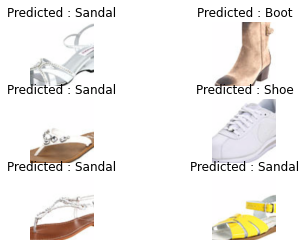

In [22]:
#Tahmin edilen vs. gerçek
vis(model_ft,6)
plt.show()

In [23]:
#Modelin h5 dosyasına kaydı
torch.save(model.state_dict(),"shoe_bot_sandal_TFL.h5")